# Project by Elodie NGANTCHOU KEMADJOU

### For the course project, i will pick any dataset of my choice and apply the concepts learned in this course to train deep learning models end-to-end with PyTorch, experimenting with different hyperparameters & metrics.

### For this project, i use Convolutional Neural Network to Classify two class weather


In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import jovian

<IPython.core.display.Javascript object>

In [3]:
project_name = "Project-course_Two-class weather classification"

In [4]:
# Librairies

import os
from random import randrange
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.models as models
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

A train dataset with 10000 jpg images, 5000 for sunny weaather and 5000 for cloudy weather. Size of the images = 200x200 pixels
A test dataset with 253 jpg images, 153 for sunny weaather and 100 for cloudy weather. Size of the images = 200x200 pixels.

[https://www.kaggle.com/polavr/twoclass-weather-classification](http://)

In [5]:
# Import dataset

# Import dataset

data_dir = '../input/twoclass-weather-classification'
print('Folders :', os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
num_classes = len(classes)
print("num weather:", num_classes)
print({cls: len(os.listdir(data_dir + f"/train/{cls}/")) for cls in sorted(classes)})
print('classes :', classes)

Folders : ['train', 'test']
num weather: 2
{'cloudy': 5000, 'sunny': 5000}
classes : ['cloudy', 'sunny']


Before we go further, we should talk a bit about the three “kinds” of data we will be interacting with; training, test, and validation.

In [6]:
transform = tt.Compose(
    [
        tt.ToTensor(), 
    ]
)

# Create datasets
train_ds = ImageFolder(data_dir+'/train', transform)
valid_ds = ImageFolder(data_dir+'/test', transform)

# set the batch size
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

classes = valid_ds.classes

sunny


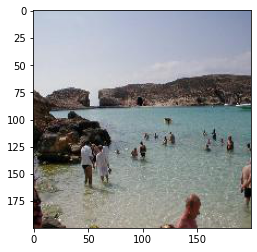

In [7]:
def show_example(data):
    [img, label] = data
    print(classes[label])
    plt.imshow(img.permute(1, 2, 0))
    
image_number = randrange(20000)
show_example(train_ds[image_number])

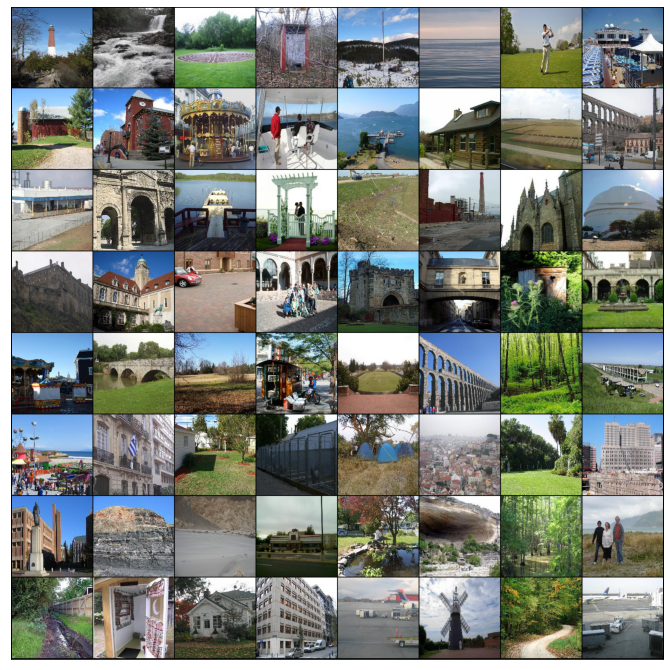

In [8]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

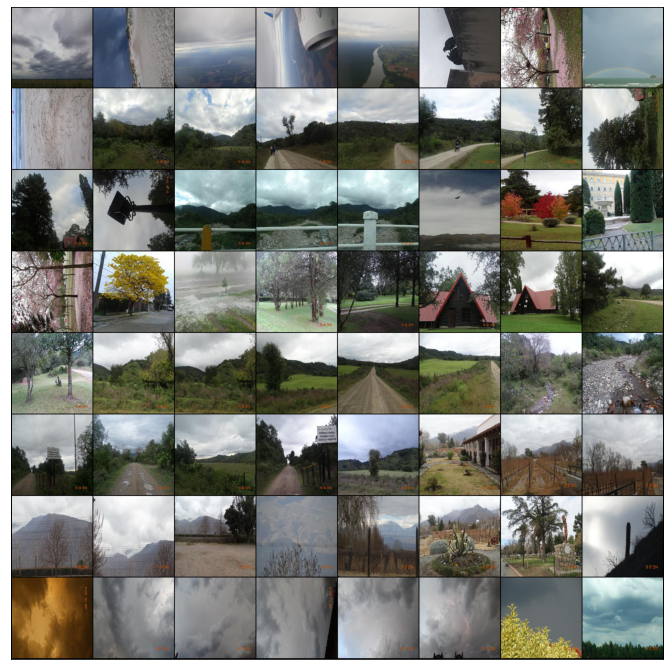

In [9]:
show_batch(valid_dl)

We use the ImageClassificationBase that we covered earlier, but we tell our network to use a pre-trained ResNet — torchvision.models.resnet34. We add a new last layer, which takes the inputs from the previous layer of the network and outputs the number of species we are classifying, as previously stated. After we move our model to the GPU

In [10]:
# pick a device
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

device = get_default_device()
device

device(type='cuda')

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [12]:
class WeartherModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [13]:
model = to_device(WeartherModel(), device)
model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


WeartherModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [14]:
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
to_device(model, device);

# print outputs for a single batch
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('all outputs:', out)
    break
    
# show the highest probability values and their index/classes
#values, indices = out.max(0)
#for index in indices :
#    print("max values", values)
#    print("max indices", index)
#    print("guesses", classes[index])
#    break
#print("max values", values)
#print("max indices", index)
#print("guesses", [classes[index] for index in indices])

images.shape: torch.Size([64, 3, 200, 200])
out.shape: torch.Size([64, 2])
all outputs: tensor([[0.5525, 0.3951],
        [0.6187, 0.4011],
        [0.5260, 0.2994],
        [0.3500, 0.4534],
        [0.2747, 0.4774],
        [0.3107, 0.4479],
        [0.6274, 0.3990],
        [0.4287, 0.5289],
        [0.2481, 0.2675],
        [0.2225, 0.4579],
        [0.4407, 0.5122],
        [0.2895, 0.2735],
        [0.2302, 0.5438],
        [0.4076, 0.3309],
        [0.3474, 0.2754],
        [0.5513, 0.5281],
        [0.4006, 0.4666],
        [0.6186, 0.2662],
        [0.3645, 0.3768],
        [0.3078, 0.5543],
        [0.4346, 0.3799],
        [0.4184, 0.3367],
        [0.3608, 0.4266],
        [0.5027, 0.3550],
        [0.3861, 0.3411],
        [0.4464, 0.4997],
        [0.4969, 0.3070],
        [0.3923, 0.4123],
        [0.3052, 0.3671],
        [0.2401, 0.4106],
        [0.4911, 0.4226],
        [0.4325, 0.4227],
        [0.2817, 0.2926],
        [0.5600, 0.3890],
        [0.4176, 0.4292],
  

In [15]:
# create the test dataset
test_dataset = ImageFolder(data_dir+'/test', tt.ToTensor())

#methods to pick a random image and make a prediciton
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

def get_random_test_image(dataset):
    rand_num = randrange(len(dataset))
    return dataset[rand_num]

We will call the fit function to train our model, which accepts a number of epochs, a learning rate, the training and validation dataloaders, and an optimization function. We will be using Stochastic Gradient Descent, or SGD here.

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.6841247081756592, 'val_acc': 0.5730937719345093}]

#### We will train for 10 epochs, use the Adam optimization function, and have a learning rate of 0.001. These properties are the “hyperparameters” of our model, and changing them can make huge differences in training and performance. You should try changing them and see how it goes!

#### Before we train — one more very important thing! Since we are using a pretrained ResNet, we will want to freeze the model so we only train the last layer (which we added).

In [18]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [19]:
# freeze the model to only train the last layer
model.freeze()

In [20]:
history = fit(num_epochs, lr, model, train_dl, valid_dl, opt_func)

Epoch [0], train_loss: 0.4314, val_loss: 0.5047, val_acc: 0.7897
Epoch [1], train_loss: 0.4105, val_loss: 0.4657, val_acc: 0.8573
Epoch [2], train_loss: 0.4032, val_loss: 0.4774, val_acc: 0.8217
Epoch [3], train_loss: 0.3925, val_loss: 0.4778, val_acc: 0.8375
Epoch [4], train_loss: 0.3943, val_loss: 0.5003, val_acc: 0.8019
Epoch [5], train_loss: 0.3869, val_loss: 0.4933, val_acc: 0.8214
Epoch [6], train_loss: 0.3892, val_loss: 0.4548, val_acc: 0.8541
Epoch [7], train_loss: 0.3872, val_loss: 0.5486, val_acc: 0.7578
Epoch [8], train_loss: 0.3824, val_loss: 0.4992, val_acc: 0.8093
Epoch [9], train_loss: 0.3769, val_loss: 0.4925, val_acc: 0.8213


#### Our model has learned quite a bit! Plotting the training/validation loss and accuracy per epoch shows that it got smart rather quickly. You might notice that the accuracy actually decreased in some epochs — this is likely a result of overfitting, which is a big problem in machine learning, but is unfortunately outside the scope of this post.

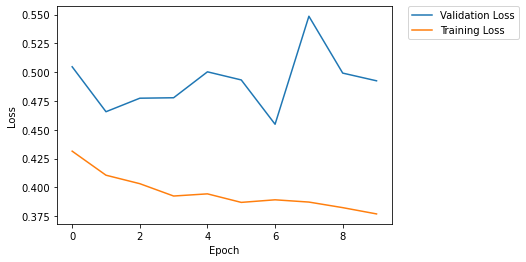

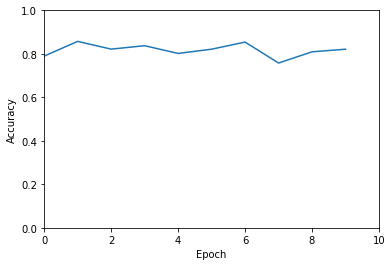

In [21]:
val_loss = [hist['val_loss'] for hist in history]
train_loss = [hist['train_loss'] for hist in history]
val_acc = [hist['val_acc'] for hist in history]
plt.plot(val_loss, label="Validation Loss")
plt.plot(train_loss, label="Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

plt.plot()
plt.plot(val_acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 10, 0, 1])
plt.show()

Label: sunny , Predicted: sunny


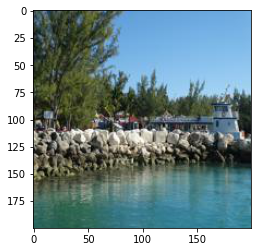

In [22]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sunny , Predicted: sunny


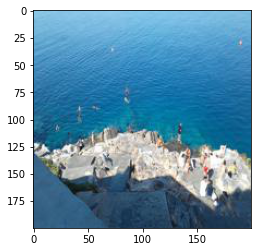

In [23]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sunny , Predicted: sunny


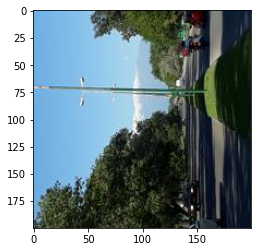

In [24]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sunny , Predicted: sunny


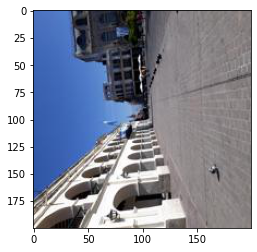

In [25]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sunny , Predicted: sunny


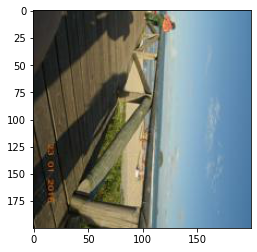

In [26]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [27]:
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DeviceDataLoader(test_loader, device)
evaluate(model, test_loader)

{'val_loss': 0.4925358295440674, 'val_acc': 0.8213124871253967}

In [28]:
!pip install jovian --upgrade --quiet

In [29]:
import jovian

In [30]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/kemadjou-elodie/Project-course_Two-class weather classification


<IPython.core.display.Javascript object>

## Data augmentation

If you’ll recall from earlier, we did a a single transformation to our images when we created the dataloader to turn each image into a tensor. There are a few other transforms we can apply to the training images to give our model a boost in training.

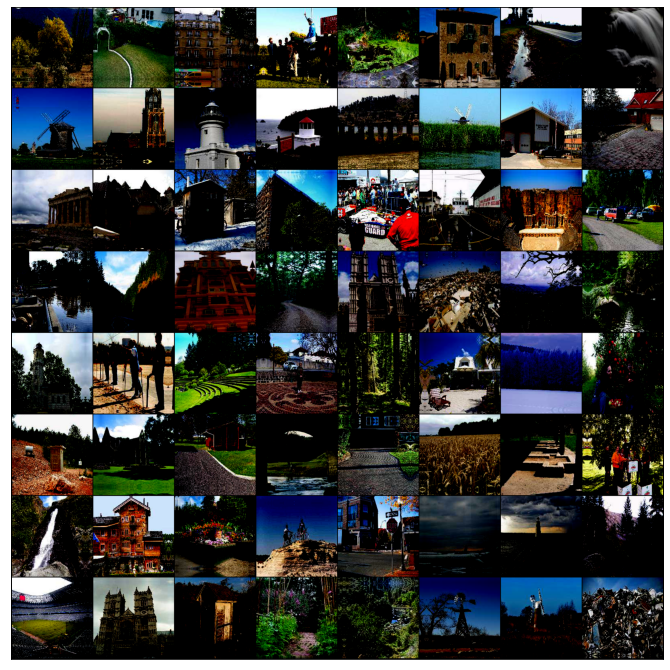

In [31]:
# some data transforms and augmentation to improve accuracy

stats = ((0.5,0.5,0.5), (0.5,0.5,0.5))
train_transform = tt.Compose(
    [
        tt.RandomCrop(200, padding=20, padding_mode='reflect'),
        tt.RandomHorizontalFlip(),
        tt.ToTensor(),
        tt.Normalize(*stats),
    ]
)
valid_transform = tt.Compose(
    [
        tt.ToTensor(), 
        tt.Normalize(*stats)
    ]
)

# Create datasets
train_ds = ImageFolder(data_dir+'/train', train_transform)
valid_ds = ImageFolder(data_dir+'/test', valid_transform)
test_ds = ImageFolder(data_dir+'/test', valid_transform)

# set the batch size
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

classes = valid_ds.classes

show_batch(train_dl)

In [37]:
# a slightly more advanced training loop for increased accuracy
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [38]:
class WeatherModel1(WeartherModel):
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [39]:
torch.cuda.empty_cache()
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = to_device(WeatherModel1(), device)
model

WeatherModel1(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [40]:
epochs = 15
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [41]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 0.7054346203804016, 'val_acc': 0.43837499618530273}]

In [42]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00015, train_loss: 0.4304, val_loss: 0.4671, val_acc: 0.8452
Epoch [1], last_lr: 0.00044, train_loss: 0.3915, val_loss: 0.4449, val_acc: 0.8574
Epoch [2], last_lr: 0.00076, train_loss: 0.4015, val_loss: 0.4758, val_acc: 0.8262
Epoch [3], last_lr: 0.00097, train_loss: 0.4061, val_loss: 0.5109, val_acc: 0.7900
Epoch [4], last_lr: 0.00099, train_loss: 0.3988, val_loss: 0.4250, val_acc: 0.8737
Epoch [5], last_lr: 0.00095, train_loss: 0.3960, val_loss: 0.4639, val_acc: 0.8416
Epoch [6], last_lr: 0.00087, train_loss: 0.3914, val_loss: 0.4024, val_acc: 0.9053
Epoch [7], last_lr: 0.00075, train_loss: 0.3911, val_loss: 0.4567, val_acc: 0.8455
Epoch [8], last_lr: 0.00061, train_loss: 0.3830, val_loss: 0.4784, val_acc: 0.8255
Epoch [9], last_lr: 0.00046, train_loss: 0.3773, val_loss: 0.5212, val_acc: 0.7699
Epoch [10], last_lr: 0.00032, train_loss: 0.3699, val_loss: 0.4424, val_acc: 0.8574
Epoch [11], last_lr: 0.00019, train_loss: 0.3653, val_loss: 0.4599, val_acc: 0.8494
Ep

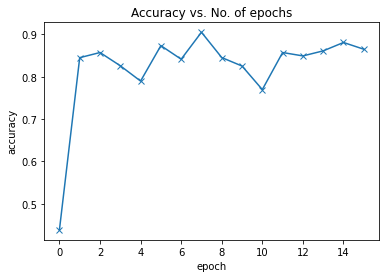

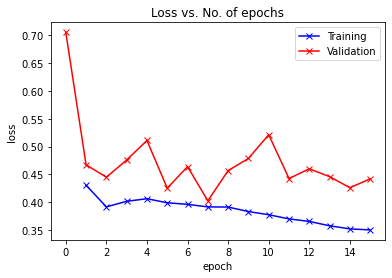

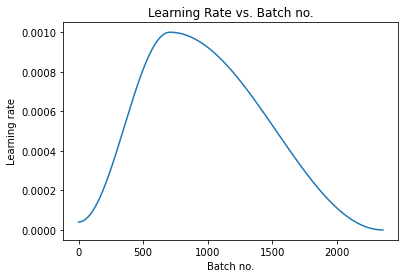

In [44]:
import numpy as np
# plot accuracy
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

# plot losses
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss vs. No. of epochs')
plt.show()

# plor learning rates
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.plot(lrs)
plt.xlabel('Batch no.')
plt.ylabel('Learning rate')
plt.title('Learning Rate vs. Batch no.')
plt.show()

Label: sunny , Predicted: sunny


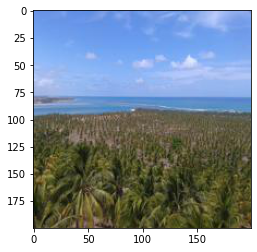

In [46]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: sunny , Predicted: cloudy


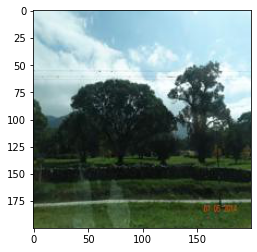

In [47]:
img, label = get_random_test_image(dataset=test_dataset)
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [48]:
evaluate(model, valid_dl)

{'val_loss': 0.44185489416122437, 'val_acc': 0.8652187585830688}

In [49]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/kemadjou-elodie/Project-course_Two-class weather classification


<IPython.core.display.Javascript object>

In [51]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/kemadjou-elodie/Project-course_Two-class weather classification


<IPython.core.display.Javascript object>